# Cloud removal Analisys

In [116]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import Resampling, calculate_default_transform, reproject
from scipy.stats import pearsonr


In [117]:
root = Path("../data/02_boa_images/sume")
metadata_path = root / 'metadata' / 'sentinel_6B_BOA_S2_SR_sume.csv'

In [118]:
root.resolve(), metadata_path.resolve()

(WindowsPath('C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/02_boa_images/sume'),
 WindowsPath('C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/02_boa_images/sume/metadata/sentinel_6B_BOA_S2_SR_sume.csv'))

In [119]:
metadata = pd.read_csv(metadata_path.resolve())
metadata = metadata[['PRODUCT_ID', 'image_id', "location_name", 'file_name', 'CLOUDY_PIXEL_PERCENTAGE', 'CLOUD_COVERAGE_ASSESSMENT']]
metadata['water_mask_image_path'] = metadata.apply(lambda x: x['file_name'].replace('02_boa_images', '07_water_masks'), axis=1)
metadata['date'] = metadata.apply(lambda x: Path(x['file_name']).name.split('_')[-1].split('.')[0], axis=1)
metadata['year'] = metadata['date'].apply(lambda date: int(f"{date[:4]}"))
metadata['month'] = metadata['date'].apply(lambda date: int(f"{date[4:6]}"))
metadata['day'] = metadata['date'].apply(lambda date: int(f"{date[6:]}"))

metadata.head()

,PRODUCT_ID,image_id,location_name,file_name,CLOUDY_PIXEL_PERCENTAGE,CLOUD_COVERAGE_ASSESSMENT,water_mask_image_path,date,year,month,day
0,S2B_MSIL2A_20180106T125259_N0500_R052_T24MYS_2...,COPERNICUS/S2_SR_HARMONIZED/20180106T125259_20...,sume,C:\Users\weverton.vitor\Documents\faculdade\pi...,32.785767,32.785767,C:\Users\weverton.vitor\Documents\faculdade\pi...,20180106,2018,1,6
1,S2A_MSIL2A_20180531T125311_N0500_R052_T24MYS_2...,COPERNICUS/S2_SR_HARMONIZED/20180531T125311_20...,sume,C:\Users\weverton.vitor\Documents\faculdade\pi...,86.369771,86.369771,C:\Users\weverton.vitor\Documents\faculdade\pi...,20180531,2018,5,31
2,S2A_MSIL2A_20181217T125301_N0211_R052_T24MYS_2...,COPERNICUS/S2_SR_HARMONIZED/20181217T125301_20...,sume,C:\Users\weverton.vitor\Documents\faculdade\pi...,80.338374,80.338374,C:\Users\weverton.vitor\Documents\faculdade\pi...,20181217,2018,12,17
3,S2B_MSIL2A_20181222T125309_N0211_R052_T24MYS_2...,COPERNICUS/S2_SR_HARMONIZED/20181222T125309_20...,sume,C:\Users\weverton.vitor\Documents\faculdade\pi...,27.804513,27.804513,C:\Users\weverton.vitor\Documents\faculdade\pi...,20181222,2018,12,22
4,S2A_MSIL2A_20181227T125301_N0211_R052_T24MYS_2...,COPERNICUS/S2_SR_HARMONIZED/20181227T125301_20...,sume,C:\Users\weverton.vitor\Documents\faculdade\pi...,0.010100,0.010100,C:\Users\weverton.vitor\Documents\faculdade\pi...,20181227,2018,12,27


In [120]:
metadata['file_name'] = metadata['file_name'].apply(lambda x: x.replace('02_boa_images', '04_clean_images'))
metadata['file_name'] = metadata['file_name'].apply(lambda x: x.replace('.tif', '_clean.tif'))
metadata['water_mask_image_path'] = metadata['water_mask_image_path'].apply(lambda x: x.replace('.tif', '_clean.tif'))

In [121]:
def plot_year_x_variable(
    data: pd.DataFrame,
    year: str,
    year_column: str='year',
    month_column: str='month',
    y_varible: str='CLOUDY_PIXEL_PERCENTAGE',
) -> None:

    filtered_data = data.loc[data[year_column] == year]
    plt.plot(filtered_data[month_column], filtered_data[y_varible])
    plt.title(f"{y_varible} - {year}")


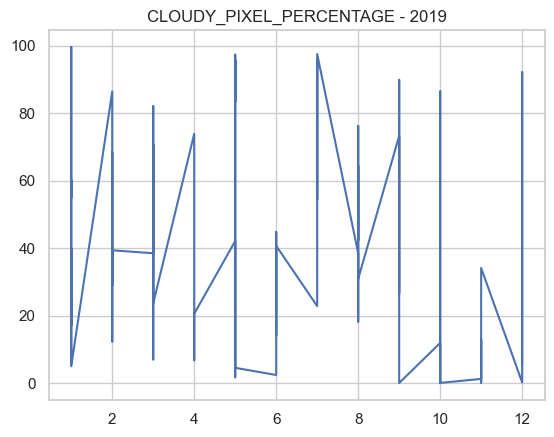

In [122]:
plot_year_x_variable(data=metadata, year=2019)

## Cloud distribution 

<Axes: >

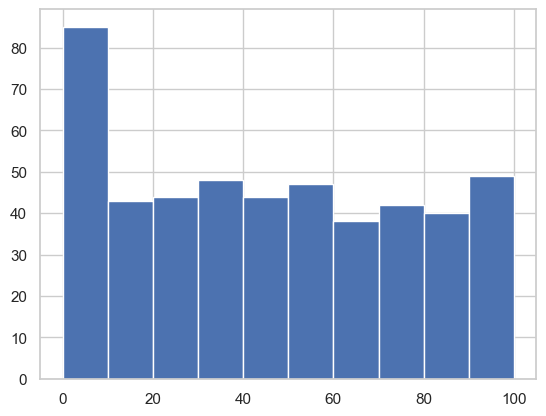

In [123]:
metadata['CLOUDY_PIXEL_PERCENTAGE'].hist()

## Water Area

In [124]:
def calcular_area_agua(tif_path):
    """
        Reprojeta uma imagem .tif com CRS geográfico (graus) para UTM (metros),
        e calcula a área de pixels de água (valor > 0).

        Parâmetros:
        - tif_path (str): caminho para o arquivo .tif

        Retorna:
        - Tuple: (area_m2, area_km2)
        """
    with rasterio.open(tif_path) as src:
        dst_crs = "EPSG:31984"  # SIRGAS 2000 / UTM zone 24S (Paraíba)

        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.MemoryFile() as memfile:
            with memfile.open(**kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )

                image = dst.read(1)
                pixel_width = abs(dst.transform.a)
                pixel_height = abs(dst.transform.e)
                pixel_area = pixel_width * pixel_height

                water_pixels = np.sum(image > 0)
                water_area_m2 = water_pixels * pixel_area
                water_area_km2 = water_area_m2 / 1e6

                return water_area_m2, water_area_km2



In [125]:
def exibir_tif(tif_path, bandas=None, titulo="Imagem .tif"):
    """
    Exibe uma imagem .tif usando rasterio e matplotlib.
    
    Parâmetros:
    - tif_path (str): caminho para o arquivo .tif
    - bandas (list[int] ou None): lista com os índices das bandas a exibir (ex: [4, 3, 2] para RGB do Sentinel-2).
                                  Se None, exibe a primeira banda como imagem em escala de cinza.
    - titulo (str): título da imagem exibida
    """
    with rasterio.open(tif_path) as src:
        if bandas:
            # Ler e empilhar as bandas escolhidas
            img = np.stack([src.read(b) for b in bandas], axis=-1).astype(np.float32)

            # Normalizar para [0, 1] para exibição
            img -= img.min()
            img /= img.max()

            plt.figure(figsize=(10, 10))

            plt.imshow(img)
        else:
            # Exibe a primeira banda em escala de cinza
            plt.figure(figsize=(10, 10))
            img = src.read(1)
            plt.imshow(img, cmap='gray')

        plt.title(titulo)
        plt.axis('off')
        plt.show()


C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2024\sentinel_6B_BOA_S2_SR_sume_20240305_clean.tif
C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\07_water_masks\sume\2024\sentinel_6B_BOA_S2_SR_sume_20240305_clean.tif
Água(m^2): 29955085.716030642
Água(km^2): 29.95508571603064


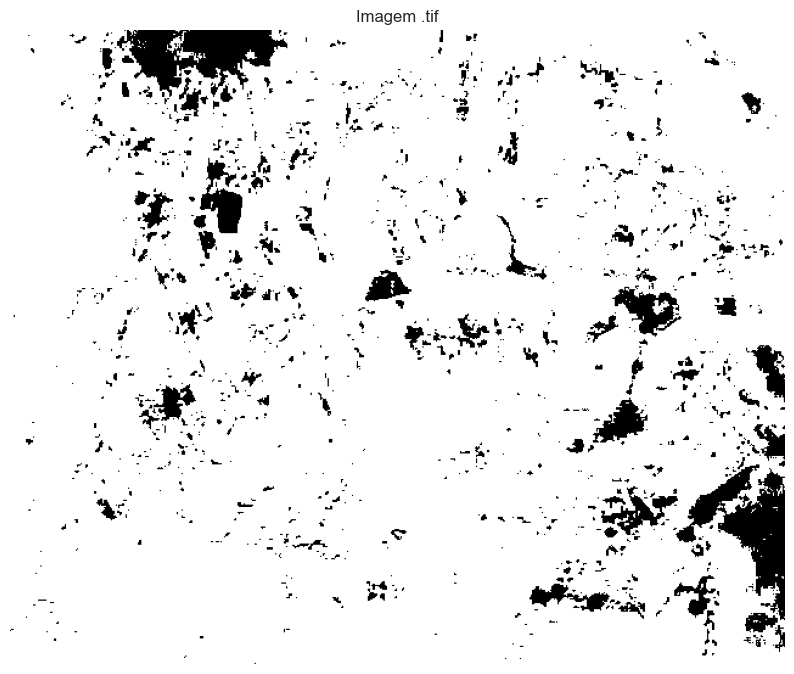

In [126]:
images = metadata['file_name']
images_water_mask = metadata['water_mask_image_path']
rand = random.randint(0, len(images))

m2, km2 = calcular_area_agua(images_water_mask[rand])
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
exibir_tif(images_water_mask[rand])

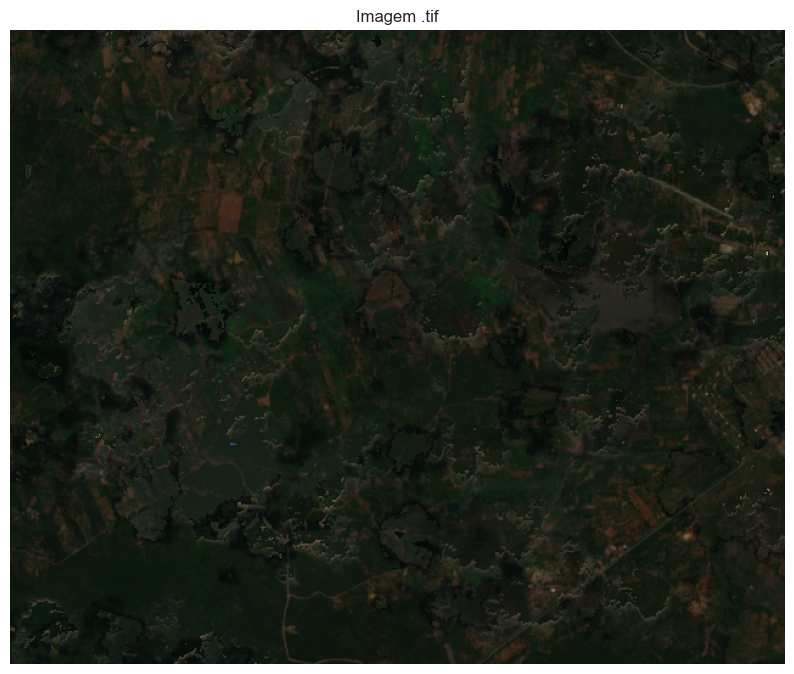

In [127]:
exibir_tif(images[rand], bandas=[4, 3, 2])

### Water Area For Many Scenes

In [129]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    try:
        m2, km2 = calcular_area_agua(row['water_mask_image_path'])
        m2_areas.append(m2)
        km2_areas.append(km2)
    except:
        print(f"Error to calculate water area of {row['water_mask_image_path']}")

metadata['m2_area'] = pd.Series(m2_areas)
metadata['km2_area'] = pd.Series(km2_areas)

Error to calculate water area of C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\07_water_masks\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif
Error to calculate water area of C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\07_water_masks\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif
Error to calculate water area of C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\07_water_masks\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif


In [130]:
metadata["m2_area"]

0      1.161022e+06
1      1.260868e+06
2      1.506444e+06
3      1.506444e+06
4      1.504081e+06
           ...     
475    7.980047e+06
476    7.768245e+06
477             NaN
478             NaN
479             NaN
Name: m2_area, Length: 480, dtype: float64

In [131]:
metadata["km2_area"]

0      1.161022
1      1.260868
2      1.506444
3      1.506444
4      1.504081
         ...   
475    7.980047
476    7.768245
477         NaN
478         NaN
479         NaN
Name: km2_area, Length: 480, dtype: float64

In [132]:
def plot_water_x_cloud_percent_filter(
    data: pd.DataFrame,
    year: int=None,
    y_varible: str='CLOUDY_PIXEL_PERCENTAGE',
    cloud_percent: int= 0
) -> None:

    filtered_data = data.loc[data["CLOUDY_PIXEL_PERCENTAGE"] <= cloud_percent]
    if year is not None:
        filtered_data = filtered_data.loc[data['year'] == year]


    water_media_data = filtered_data.groupby('month')[y_varible].mean()
    water_media_data = water_media_data.to_dict()

    water_months = {x:0 for x in range(1, 13)}
    water_months.update(water_media_data)

    plt.plot(list(water_months.keys()), list(water_months.values()))
    plt.title(f"{y_varible} - {year} (cloud: {cloud_percent}%)")


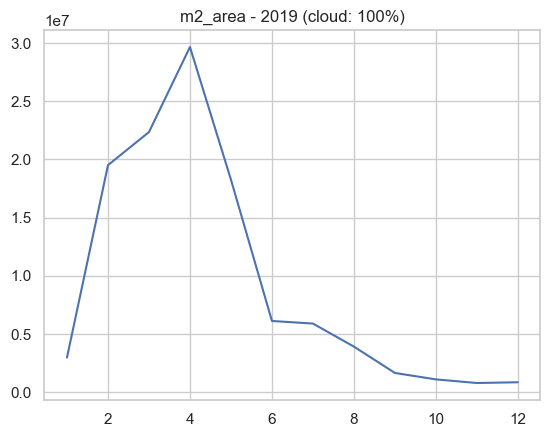

In [133]:
plot_water_x_cloud_percent_filter(data=metadata, year=2019, y_varible="m2_area", cloud_percent=100)

In [145]:
def plot_water_x_cloud_percent(
    data: pd.DataFrame,
    year: int = None,
    y_variable: str = 'CLOUDY_PIXEL_PERCENTAGE'
) -> None:
    """
    Plota a média mensal da variável `y_variable` para diferentes faixas de cobertura de nuvens (0 a 100%, de 10 em 10%).

    Parâmetros:
    - data (pd.DataFrame): DataFrame com colunas 'CLOUDY_PIXEL_PERCENTAGE', 'year', 'month', e a variável desejada.
    - year (int, opcional): Ano a ser filtrado.
    - y_variable (str): Nome da variável a ser analisada (default: 'CLOUDY_PIXEL_PERCENTAGE').
    """
    plt.figure(figsize=(12, 8))
    
    for cloud_percent in range(0, 101, 10):
        filtered_data = data[data["CLOUDY_PIXEL_PERCENTAGE"] <= cloud_percent]
        
        if year is not None:
            filtered_data = filtered_data[filtered_data['year'] == year]
        
        # Calcula a média mensal da variável
        monthly_means = filtered_data.groupby('month')[y_variable].mean().to_dict()
        
        # Garante que todos os meses (1 a 12) estejam presentes, mesmo que com valor 0
        all_months = {month: 0 for month in range(1, 13)}
        all_months.update(monthly_means)
        
        plt.plot(list(all_months.keys()), list(all_months.values()), label=f'≤ {cloud_percent}%')

    plt.title(f'Média mensal de {y_variable} ({f"ano " + str(year) if year else "todos os anos"})\npara diferentes filtros de cobertura de nuvem')
    plt.xlabel('Mês')
    plt.ylabel(f'Média de {y_variable}')
    plt.xticks(range(1, 13))
    plt.legend(title='Cobertura de Nuvem')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_monthly_water(
    data: pd.DataFrame,
    year: int = None,
    y_variable: str = 'm2_area'  # Altere para o nome da sua variável de interesse
) -> None:
    """
    Plota a média mensal da variável `y_variable`.

    Parâmetros:
    - data (pd.DataFrame): DataFrame com colunas 'year', 'month' e a variável desejada.
    - year (int, opcional): Ano a ser filtrado (default: None = todos os anos).
    - y_variable (str): Nome da variável a ser analisada.
    """
    if year is not None:
        data = data[data['year'] == year]

    # Calcula a média mensal da variável
    monthly_means = data.groupby('month')[y_variable].mean().to_dict()

    # Garante que todos os meses (1 a 12) estejam presentes
    all_months = {month: 0 for month in range(1, 13)}
    all_months.update(monthly_means)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(
        list(all_months.keys()), 
        list(all_months.values()), 
        marker='o'
    )

    plt.title(f'Média mensal de {y_variable} ' + (f'(ano {year})' if year else '(todos os anos)'))
    plt.xlabel('Mês')
    plt.ylabel(f'Média de {y_variable}')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


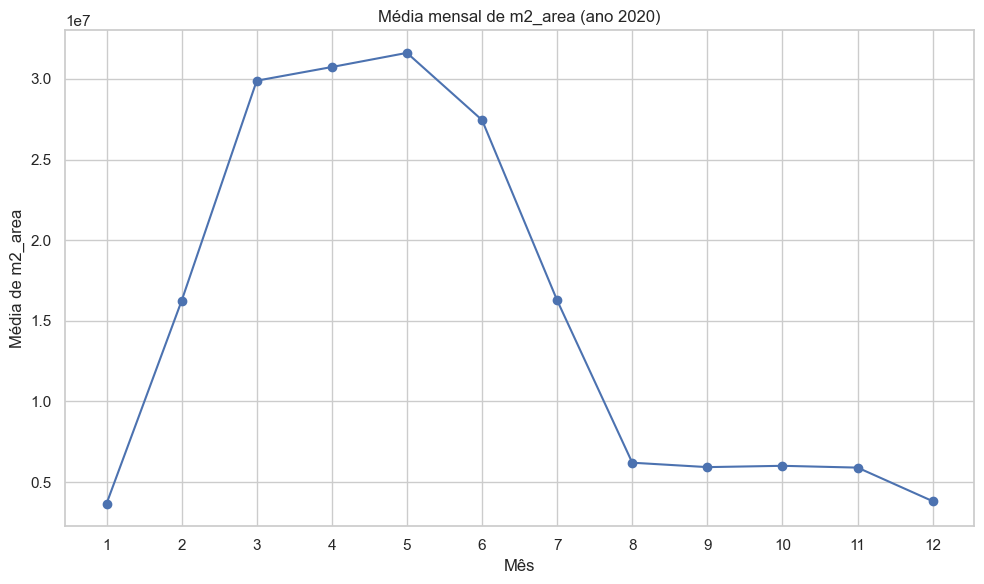

In [ ]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area')

In [143]:
def plot_water_x_cloud_percent_over_time(
    data: pd.DataFrame,
    y_variable: str = 'CLOUDY_PIXEL_PERCENTAGE'
) -> None:
    """
    Plota a média mensal da variável `y_variable` ao longo do tempo (ano + mês),
    para diferentes faixas de cobertura de nuvens (0 a 100%, de 10 em 10%).

    Parâmetros:
    - data (pd.DataFrame): DataFrame com colunas 'CLOUDY_PIXEL_PERCENTAGE', 'year', 'month' e a variável desejada.
    - y_variable (str): Nome da variável a ser analisada.
    """
    # Garante que a coluna de tempo esteja ordenada corretamente
    data = data.copy()
    data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
    data.sort_values('date', inplace=True)

    plt.figure(figsize=(14, 7))

    for cloud_percent in range(0, 101, 10):
        filtered_data = data[data["CLOUDY_PIXEL_PERCENTAGE"] <= cloud_percent]

        # Média mensal da variável para essa faixa de nuvem
        grouped = (
            filtered_data.groupby('date')[y_variable]
            .mean()
            .sort_index()
        )

        plt.plot(grouped.index, grouped.values, label=f'≤ {cloud_percent}%')

    plt.title(f'Média mensal de {y_variable} por faixa de cobertura de nuvens')
    plt.xlabel('Tempo (Ano/Mês)')
    plt.ylabel(f'Média de {y_variable}')
    plt.grid(True)
    plt.legend(title='Cobertura de Nuvem (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_water_over_time(
    data: pd.DataFrame,
    y_variable: str = 'water_area'  # Altere conforme o nome real da sua variável
) -> None:
    """
    Plota a média mensal da variável `y_variable` ao longo do tempo (ano + mês).

    Parâmetros:
    - data (pd.DataFrame): DataFrame com colunas 'year', 'month' e a variável desejada.
    - y_variable (str): Nome da variável a ser analisada.
    """
    # Cria a coluna de data (1º dia de cada mês)
    data = data.copy()
    data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

    # Calcula a média mensal
    monthly_mean = (
        data.groupby('date')[y_variable]
        .mean()
        .sort_index()
    )

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_mean.index, monthly_mean.values, marker='o')
    plt.title(f'Média mensal de {y_variable} ao longo do tempo')
    plt.xlabel('Tempo (Ano/Mês)')
    plt.ylabel(f'Média de {y_variable}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



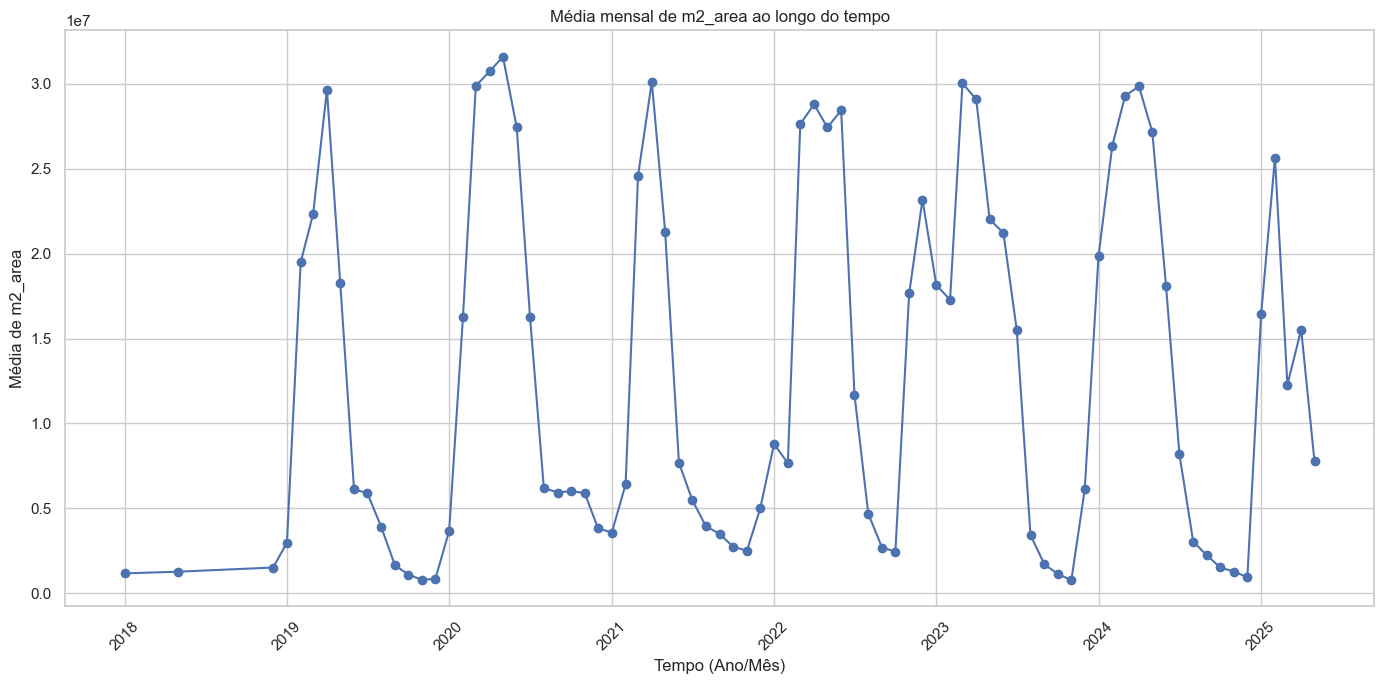

In [144]:
plot_water_over_time(metadata, y_variable='m2_area')